In [19]:
!tree -L 3


.
├── README.md
├── data
│   ├── 5b1802ef89579c0ed05e707f96177cab.grib
│   ├── 5b1802ef89579c0ed05e707f96177cab.grib.5b7b6.idx
│   ├── DEM.tif
│   ├── LCFM_LCM-10_V100_2020_N21E084_cog
│   │   └── LCFM_LCM-10_V100_2020_N21E084_MAP.tif
│   ├── aspect.tif
│   ├── features_full_stack.tif
│   ├── features_static_stack.tif
│   ├── features_weather_stack.tif
│   ├── fire_vriis.csv
│   ├── fuel_reclass.tif
│   ├── slope.tif
│   └── tiles
│       ├── tile_0_0.tif
│       ├── tile_0_1024.tif
│       ├── tile_0_1280.tif
│       ├── tile_0_1536.tif
│       ├── tile_0_1792.tif
│       ├── tile_0_2048.tif
│       ├── tile_0_2304.tif
│       ├── tile_0_256.tif
│       ├── tile_0_2560.tif
│       ├── tile_0_2816.tif
│       ├── tile_0_3072.tif
│       ├── tile_0_3328.tif
│       ├── tile_0_512.tif
│       ├── tile_0_768.tif
│       ├── tile_1024_0.tif
│       ├── tile_1024_1024.tif
│       ├── tile_1024_1280.tif
│       ├── tile_1024_1536.tif
│       ├── tile_1024_1792.tif
│       ├── tile_1024_2048.

# STACKING

In [12]:
import numpy as np
import rasterio
from rasterio.enums import Resampling

# Data Paths
dem_fp        = "data/DEM.tif"
lulc_fp       = "data/LCFM_LCM-10_V100_2020_N21E084_cog/LCFM_LCM-10_V100_2020_N21E084_MAP.tif"
slope_fp      = "data/slope.tif"
aspect_fp     = "data/aspect.tif"
fuel_fp       = "data/fuel_reclass.tif"

# READ DEM
with rasterio.open(dem_fp) as src:
    dem      = src.read(1).astype("float32")
    transform= src.transform
    profile  = src.profile.copy()

# compute pixel size
xres = transform.a
yres = -transform.e

# gradients
dz_dy, dz_dx = np.gradient(dem, yres, xres)

# slope in degrees
slope = np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2)))

# aspect in degrees
aspect = np.degrees(np.arctan2(dz_dy, -dz_dx))
aspect = np.where(aspect < 0,
                  90.0 - aspect,
                  360.0 - aspect + 90.0)
aspect = np.where((dz_dx == 0) & (dz_dy == 0), -1, aspect)

# update profile for single band float outputs
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress="lzw",
    nodata=-1
)

# slope
with rasterio.open(slope_fp, "w", **profile) as dst:
    dst.write(slope.astype(rasterio.float32), 1)

# aspect
with rasterio.open(aspect_fp, "w", **profile) as dst:
    dst.write(aspect.astype(rasterio.float32), 1)

print(" Slope & aspect written to:", slope_fp, aspect_fp)


# READ LULC & reclassify to fuel score
#    WorldCover codes → fuel: 10->3, 20->2, 30->1, 40->1, others (50+) ->0
with rasterio.open(lulc_fp) as src:
    lulc = src.read(1)
    fuel_profile = src.profile.copy()
    
# build empty fuel array
fuel = np.zeros_like(lulc, dtype=np.uint8)

# apply mapping
fuel[np.isin(lulc, [10])] = 3
fuel[np.isin(lulc, [20])] = 2
fuel[np.isin(lulc, [30, 40])] = 1
# all other values remain 0

# update profile
fuel_profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress="lzw",
    nodata=0
)

# write fuel raster
with rasterio.open(fuel_fp, "w", **fuel_profile) as dst:
    dst.write(fuel, 1)

print("Fuel raster written to:", fuel_fp)


 Slope & aspect written to: data/slope.tif data/aspect.tif
Fuel raster written to: data/fuel_reclass.tif


In [13]:
import rasterio
import numpy as np
from rasterio.enums import Resampling
from rasterio.warp import reproject

# Input rasters
inputs = {
    "slope" : "data/slope.tif",
    "aspect": "data/aspect.tif",
    "fuel"  : "data/fuel_reclass.tif"
}
output_path = "data/features_static_stack.tif"

# Open reference (slope) to get grid/CRS
with rasterio.open(inputs["slope"]) as ref:
    ref_meta = ref.meta.copy()
    ref_transform, ref_crs = ref.transform, ref.crs
    height, width = ref.height, ref.width

# Prepare output metadata
ref_meta.update({
    "count": len(inputs),
    "dtype": "float32",
    "compress": "lzw",
    "nodata": -9999
})

# Create stacked file
with rasterio.open(output_path, "w", **ref_meta) as dst:
    for idx, (name, path) in enumerate(inputs.items(), start=1):
        with rasterio.open(path) as src:
            src_data = src.read(1)
            # If same grid, no reprojection needed
            if (src.transform == ref_transform 
                and src.crs == ref_crs 
                and src.width == width 
                and src.height == height):
                band = src_data.astype("float32")
            else:
                # Allocate empty array for resampled data
                band = np.empty((height, width), dtype="float32")
                # Reproject/resample into our reference grid
                reproject(
                    source=src_data,
                    destination=band,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.bilinear,
                )
        dst.write(band, idx)
        dst.set_band_description(idx, name)

print(f" Static feature stack saved to {output_path}")


 Static feature stack saved to data/features_static_stack.tif


In [14]:
!pip install xarray cfgrib rasterio

In [15]:
import xarray as xr

grib_fp = "data/5b1802ef89579c0ed05e707f96177cab.grib"
ds = xr.open_dataset(grib_fp, engine="cfgrib")

# List all data variables in the dataset
print(ds)
print("\nData variables available:")
for name in ds.data_vars:
    print(" -", name)


skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/anaconda3/lib/python3.12/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1612137600, 1612141200, 1612144800, ..., 1617224400, 1617228000,
       1617231600])) new_value=Variable(dimensions=('time',), data=array([1612116000, 1612159200, 1612202400, 1612245600, 1612288800,
       1612332000, 1612375200, 1612418400, 1612461600, 1612504800,
       1612548000, 1612591200, 1612634400, 1612677600, 1612720800,
       1612764000, 1612807200, 1612850400, 1612893600, 1612936800,
       1612980000, 1613023200, 1613066400, 1613109600, 1613152800,
       1613196000, 1613239200, 1613282400, 1

<xarray.Dataset> Size: 136kB
Dimensions:     (time: 1416, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 11kB 2021-02-01 ... 2021-03-31T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 16B 21.93 21.68
  * longitude   (longitude) float64 16B 86.0 86.25
    valid_time  (time) datetime64[ns] 11kB ...
Data variables:
    u10         (time, latitude, longitude) float32 23kB ...
    v10         (time, latitude, longitude) float32 23kB ...
    d2m         (time, latitude, longitude) float32 23kB ...
    t2m         (time, latitude, longitude) float32 23kB ...
    sp          (time, latitude, longitude) float32 23kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Eu

/opt/anaconda3/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


# TILING

In [16]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds

# Paths
grib_fp      = "data/5b1802ef89579c0ed05e707f96177cab.grib"
ref_fp       = "data/features_static_stack.tif"
weather_fp   = "data/features_weather_stack.tif"

vars_info = {
    "t2m": "mean",
    "d2m": "mean",
    "u10": "mean",
    "v10": "mean",
    "sp":  "mean"
}

# Open ref for grid
with rasterio.open(ref_fp) as ref:
    meta   = ref.meta.copy()
    transform, crs = ref.transform, ref.crs
    h, w  = ref.height, ref.width

# update for 5 weather bands
meta.update(count=len(vars_info), dtype="float32", compress="lzw", nodata=-9999)

# Load GRIB via xarray
ds = xr.open_dataset(grib_fp, engine="cfgrib")
lons, lats = ds.longitude.values, ds.latitude.values
src_transform = from_bounds(lons.min(), lats.min(), lons.max(), lats.max(),
                            lons.size, lats.size)
src_crs = "EPSG:4326"

# Write weather stack
with rasterio.open(weather_fp, "w", **meta) as dst:
    for i, (var, agg) in enumerate(vars_info.items(), start=1):
        arr = getattr(ds[var], agg)(dim="time").values.squeeze().astype("float32")
        buf = np.empty((h, w), dtype="float32")
        reproject(arr, buf,
                  src_transform=src_transform, src_crs=src_crs,
                  dst_transform=transform,  dst_crs=crs,
                  resampling=Resampling.bilinear)
        dst.write(buf, i)
        dst.set_band_description(i, var)

print(" Weather stack written to", weather_fp)


skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/anaconda3/lib/python3.12/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1612137600, 1612141200, 1612144800, ..., 1617224400, 1617228000,
       1617231600])) new_value=Variable(dimensions=('time',), data=array([1612116000, 1612159200, 1612202400, 1612245600, 1612288800,
       1612332000, 1612375200, 1612418400, 1612461600, 1612504800,
       1612548000, 1612591200, 1612634400, 1612677600, 1612720800,
       1612764000, 1612807200, 1612850400, 1612893600, 1612936800,
       1612980000, 1613023200, 1613066400, 1613109600, 1613152800,
       1613196000, 1613239200, 1613282400, 1

 Weather stack written to data/features_weather_stack.tif


In [17]:
import rasterio
from rasterio.merge import merge

static_fp  = "data/features_static_stack.tif"
weather_fp = "data/features_weather_stack.tif"
out_fp     = "data/features_full_stack.tif"

# open both
srcs = [rasterio.open(static_fp), rasterio.open(weather_fp)]

# same grid/crs: just merge bands
meta = srcs[0].meta.copy()
meta.update(count=srcs[0].count + srcs[1].count)

with rasterio.open(out_fp, "w", **meta) as dst:
    # write static bands
    for b in range(1, srcs[0].count+1):
        dst.write(srcs[0].read(b), b)
    # write weather bands
    for b in range(1, srcs[1].count+1):
        dst.write(srcs[1].read(b), srcs[0].count + b)

print("Full feature stack saved to", out_fp)


Full feature stack saved to data/features_full_stack.tif


In [18]:
import os
import rasterio
from rasterio.windows import Window
import numpy as np

stack_fp = "data/features_full_stack.tif"
out_dir  = "data/tiles"
tile_size = 256
os.makedirs(out_dir, exist_ok=True)

with rasterio.open(stack_fp) as src:
    for i in range(0, src.height, tile_size):
        for j in range(0, src.width, tile_size):
            if i + tile_size <= src.height and j + tile_size <= src.width:
                window = Window(j, i, tile_size, tile_size)
                data = src.read(window=window)
                out_meta = src.meta.copy()
                out_meta.update({
                    "height": tile_size,
                    "width": tile_size,
                    "transform": rasterio.windows.transform(window, src.transform)
                })
                tile_fp = os.path.join(out_dir, f"tile_{i}_{j}.tif")
                with rasterio.open(tile_fp, "w", **out_meta) as dst:
                    dst.write(data)


# NORMALISATION and SPLITTING

In [2]:
import os, glob, random

tiles_dir = "data/tiles"
paths = sorted(glob.glob(os.path.join(tiles_dir, "*.tif")))
random.shuffle(paths)
split = int(len(paths) * 0.8)
train_paths = paths[:split]
val_paths = paths[split:]

os.makedirs("data/splits", exist_ok=True)
with open("data/splits/train_tiles.txt", "w") as f:
    f.write("\n".join(train_paths))
with open("data/splits/val_tiles.txt", "w") as f:
    f.write("\n".join(val_paths))


In [3]:
import os, json
import numpy as np
import rasterio
from glob import glob
from tqdm import tqdm

# --- Config ---
norm_file     = "data/splits/norm_stats.json"
fuel_band_idx = 2  # zero-based index
in_dir        = "data/tiles"
out_dir       = "data/tiles_norm"

# Load stats
with open(norm_file) as f:
    stats = json.load(f)
means = np.array(stats["means"])
stds  = np.array(stats["stds"])

# Load tile paths
with open("data/splits/train_tiles.txt") as f:
    train_paths = f.read().splitlines()
with open("data/splits/val_tiles.txt") as f:
    val_paths = f.read().splitlines()

def process_tile(fp, dest):
    with rasterio.open(fp) as src:
        arr  = src.read().astype("float32")
        meta = src.meta.copy()
        nod  = src.nodata
        mask = (arr != nod)

    # Normalize (z-score)
    normed = (arr - means[:, None, None]) / stds[:, None, None]
    normed[~mask] = 0

    # One-hot encode fuel band
    fuel = np.clip(np.rint(arr[fuel_band_idx]), 0, 3).astype("uint8")
    oh = np.stack([(fuel == i).astype("float32") for i in range(4)], axis=0)

    # Drop fuel band, add one-hot channels
    cont = np.delete(normed, fuel_band_idx, axis=0)
    final = np.concatenate([cont, oh], axis=0)

    # Update meta and write
    meta.update(count=final.shape[0], dtype="float32", nodata=0)
    os.makedirs(os.path.dirname(dest), exist_ok=True)
    with rasterio.open(dest, "w", **meta) as dst:
        dst.write(final)

# Process in batches
for split, paths in [("train", train_paths), ("val", val_paths)]:
    print(f"→ Processing {split} tiles")
    for fp in tqdm(paths):
        out_fp = os.path.join(out_dir, split, os.path.basename(fp))
        process_tile(fp, out_fp)


→ Processing train tiles


100%|██████████| 156/156 [00:02<00:00, 63.03it/s]


→ Processing val tiles


100%|██████████| 40/40 [00:00<00:00, 91.85it/s]


Visualizing: tile_2048_2304.tif


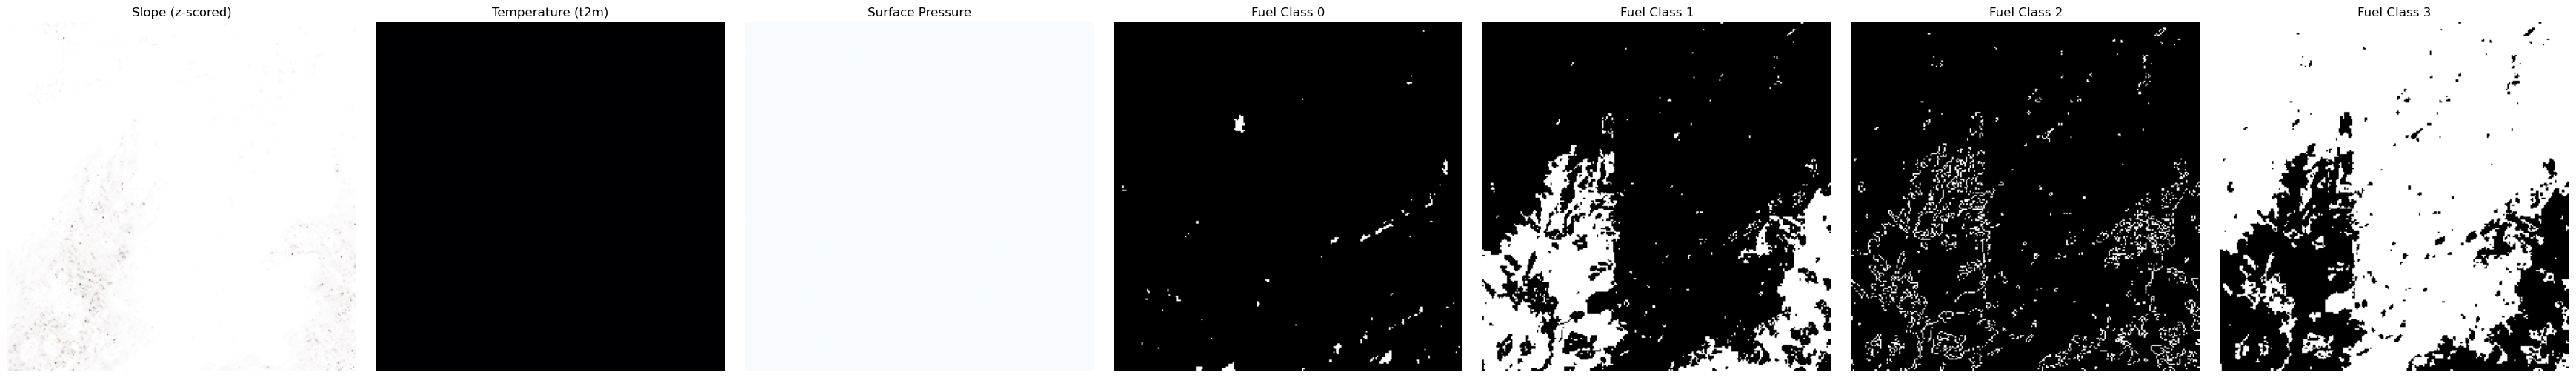

In [7]:
import os
import glob
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# --- Config ---
tile_dir = "data/tiles_norm/train"
tile_paths = sorted(glob.glob(os.path.join(tile_dir, "*.tif")))
sample = random.choice(tile_paths)

print(f"Visualizing: {os.path.basename(sample)}")

# Load image
with rasterio.open(sample) as src:
    img = src.read()

# Determine how many one-hot fuel bands exist (after band 6)
n_fuel_bands = img.shape[0] - 7

# Create figure layout: 3 base bands + N fuel bands
fig, axs = plt.subplots(1, 3 + n_fuel_bands, figsize=(5 * (3 + n_fuel_bands), 5))

# Base continuous bands
axs[0].imshow(img[0], cmap="terrain")
axs[0].set_title("Slope (z-scored)")

axs[1].imshow(img[5], cmap="inferno")
axs[1].set_title("Temperature (t2m)")

axs[2].imshow(img[6], cmap="Blues")
axs[2].set_title("Surface Pressure")

# One-hot fuel bands
for i in range(n_fuel_bands):
    axs[i + 3].imshow(img[7 + i], cmap="gray")
    axs[i + 3].set_title(f"Fuel Class {i}")

# Clean up
for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Data Loaders for Pytorch

In [8]:
import os
import torch
import rasterio
import numpy as np
from torch.utils.data import Dataset

class FireTileDataset(Dataset):
    def __init__(self, tile_list, feature_root, label_root, augment=False):
        with open(tile_list) as f:
            self.filenames = [os.path.basename(p.strip()) for p in f]
        self.feature_root = feature_root
        self.label_root   = label_root
        self.augment = augment  

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]

        # Load feature tile
        feat_path = os.path.join(self.feature_root, fname)
        with rasterio.open(feat_path) as src:
            x = src.read().astype("float32")  

        # Load label tile (binary mask)
        label_path = os.path.join(self.label_root, fname)
        with rasterio.open(label_path) as src:
            y = src.read(1).astype("float32")  

        # Convert to torch tensors
        x = torch.from_numpy(x)
        y = torch.from_numpy(y).unsqueeze(0)  
        return x, y


In [9]:
from torch.utils.data import DataLoader

train_ds = FireTileDataset(
    tile_list="data/splits/train_tiles.txt",
    feature_root="data/tiles_norm/train",
    label_root="data/labels/train"
)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=11, out_channels=1):
        super().__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 512))

        self.up1 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 256)

        self.up2 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 128)

        self.up3 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x1 = self.inc(x)       # 64
        x2 = self.down1(x1)    # 128
        x3 = self.down2(x2)    # 256
        x4 = self.down3(x3)    # 512
        x5 = self.down4(x4)    # 512

        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x4], dim=1))

        x = self.up2(x)
        x = self.conv2(torch.cat([x, x3], dim=1))

        x = self.up3(x)
        x = self.conv3(torch.cat([x, x2], dim=1))

        x = self.up4(x)
        x = self.conv4(torch.cat([x, x1], dim=1))

        return torch.sigmoid(self.outc(x))  


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset & Loader
train_ds = FireTileDataset("data/splits/train_tiles.txt", "data/tiles_norm/train", "data/labels/train")
val_ds   = FireTileDataset("data/splits/val_tiles.txt",   "data/tiles_norm/val",   "data/labels/val")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)

# Model, loss, optimizer
model = UNet(in_channels=11, out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import torch
import rasterio
import numpy as np
import glob
import random
import os

val_tile_paths = glob.glob("data/tiles_norm/val/*.tif")
sample_tile = random.choice(val_tile_paths)
print(f"Inference on: {os.path.basename(sample_tile)}")

# Load tile
with rasterio.open(sample_tile) as src:
    arr = src.read().astype("float32")
    meta = src.meta.copy()

x = torch.from_numpy(arr).unsqueeze(0).to(device)  

# Run model
model.eval()
with torch.no_grad():
    prob = model(x).squeeze().cpu().numpy() 

# Save probability map
meta.update(count=1, dtype="float32")
os.makedirs("outputs", exist_ok=True)

with rasterio.open("outputs/fire_prob.tif", "w", **meta) as dst:
    dst.write(prob, 1)

# Save thresholded binary mask
binary = (prob > 0.3).astype("uint8")
meta.update(dtype="uint8")
with rasterio.open("outputs/fire_binary.tif", "w", **meta) as dst:
    dst.write(binary, 1)

print(" Saved: outputs/fire_prob.tif and outputs/fire_binary.tif")


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) × 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=11, out_channels=1):
        super().__init__()

        self.inc   = DoubleConv(in_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 512))

        self.up1   = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 256)

        self.up2   = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 128)

        self.up3   = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 64)

        self.up4   = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.outc  = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)       
        x2 = self.down1(x1)   
        x3 = self.down2(x2)    
        x4 = self.down3(x3)    
        x5 = self.down4(x4)    
        x = self.up1(x5)      
        x = self.conv1(torch.cat([x, x4], dim=1))  # skip conn

        x = self.up2(x)       
        x = self.conv2(torch.cat([x, x3], dim=1))

        x = self.up3(x)       
        x = self.conv3(torch.cat([x, x2], dim=1))

        x = self.up4(x)        
        x = self.conv4(torch.cat([x, x1], dim=1))

        return torch.sigmoid(self.outc(x))  # Final output: (B, 1, 256, 256)


In [ ]:
import os
import pandas as pd
import rasterio
from rasterio.features import rasterize
from shapely.geometry import Point
from rasterio.windows import Window
import glob

# ─── 1) Rasterize full‐extent label ───
df = pd.read_csv("data/fire_vriis.csv", parse_dates=["acq_date"])


# Reference grid from full feature stack
with rasterio.open("data/features_full_stack.tif") as ref:
    meta = ref.meta.copy()
    transform, h, w = ref.transform, ref.height, ref.width

# Make geometries
geoms = [(Point(lon, lat), 1) 
         for lon, lat in df[["longitude","latitude"]].values]

# Rasterize to binary mask
mask = rasterize(
    geoms,
    out_shape=(h, w),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
)

# Save full mask
os.makedirs("data", exist_ok=True)
meta.update(count=1, dtype="uint8", nodata=0) 
with rasterio.open("data/labels_full.tif", "w", **meta) as dst:
    dst.write(mask, 1)

print("Saved full label raster: data/labels_full.tif")


# ─── 2) Tile the label raster to train/val folders ───
label_full_fp = "data/labels_full.tif"
tile_list_train = [os.path.basename(p).strip() 
                   for p in open("data/splits/train_tiles.txt")]
tile_list_val   = [os.path.basename(p).strip() 
                   for p in open("data/splits/val_tiles.txt")]

# Create output dirs
for subset in ["train", "val"]:
    os.makedirs(f"data/labels/{subset}", exist_ok=True)

with rasterio.open(label_full_fp) as src:
    for tile_list, subset in [(tile_list_train, "train"), (tile_list_val, "val")]:
        for fname in tile_list:
            # derive window from filename
            _, col, row = fname.replace(".tif","").split("_")
            col, row = int(col), int(row)
            window = Window(col, row, 256, 256)

            out_meta = src.meta.copy()
            out_meta.update({
                "height": 256,
                "width": 256,
                "transform": rasterio.windows.transform(window, src.transform),
                "count": 1,
                "dtype": "uint8",
                "nodata": 0
            })

            patch = src.read(1, window=window)
            out_fp = f"data/labels/{subset}/{fname}"
            with rasterio.open(out_fp, "w", **out_meta) as dst:
                dst.write(patch, 1)

print("Tiled labels into data/labels/train & data/labels/val")


In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets & Loaders (with valid labels now in data/labels/)
train_ds = FireTileDataset(
    "data/splits/train_tiles.txt",
    "data/tiles_norm/train",
    "data/labels/train"
)
val_ds = FireTileDataset(
    "data/splits/val_tiles.txt",
    "data/tiles_norm/val",
    "data/labels/val"
)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=0)

# Model, loss, optimizer
model = UNet(in_channels=11, out_channels=1).to(device)
criterion = nn.BCELoss()   # or FocalLoss if you defined it
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# IoU metric
def compute_iou(preds, targets, thresh=0.5):
    preds = (preds > thresh).float()
    inter = (preds * targets).sum()
    union = (preds + targets - preds*targets).sum()
    return (inter + 1e-6) / (union + 1e-6)

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X, Y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, Y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(train_loader)

    model.eval()
    ious = []
    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            ious.append(compute_iou(pred, Y).item())
    avg_iou = np.mean(ious)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Val IoU={avg_iou:.4f}")

# Save the trained model
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/unet_final.pth")
print("Training complete, model saved to models/unet_final.pth")


Epoch 1/10 [Train]: 100%|██████████| 39/39 [03:04<00:00,  4.72s/it]


Epoch 1: Loss=0.6382, Val IoU=0.0001


Epoch 2/10 [Train]: 100%|██████████| 39/39 [03:53<00:00,  5.99s/it]


Epoch 2: Loss=0.4612, Val IoU=0.0000


Epoch 3/10 [Train]:  85%|████████▍ | 33/39 [03:54<00:38,  6.34s/it]